# 🎬 Netflix Movies and TV Shows: Exploratory Data Analysis (EDA)

## Introduction
Netflix is one of the most popular media and video streaming platforms globally. This notebook explores the Netflix dataset to understand content trends, distribution between movies and TV shows, and duration analysis.

## Objectives
1.  **Data Cleaning:** Handling missing values and data type conversions.
2.  **Content Analysis:** Comparing the ratio of Movies vs. TV Shows.
3.  **Trend Analysis:** How has content production changed over the years?
4.  **Duration Analysis:** What is the distribution of movie lengths?
5.  **Word Cloud:** Common Words in Titles

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Loading the dataset
# Note: In Kaggle, datasets are usually in the '../input/' directory
df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')

# Displaying the first 5 rows
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## 🧹 Data Cleaning & Preprocessing

We observed missing values in `director`, `cast`, and `country`. Since these are categorical, we will fill them with "Unknown". For critical columns like `date_added`, `rating`, and `duration` which have very few missing values, we will drop those rows to maintain data integrity.

In [3]:
# 1. Dropping rows with minimal missing values (Critical for analysis)
df.dropna(subset=['date_added', 'rating', 'duration'], inplace=True)

# 2. Filling missing values in categorical columns
df['country'].fillna('Unknown', inplace=True)
df['cast'].fillna('No Cast', inplace=True)
df['director'].fillna('No Director', inplace=True)

# 3. Converting Date Format
# We need to convert 'date_added' to datetime objects to extract Year and Month
df["date_added"] = pd.to_datetime(df['date_added'].str.strip(), errors='coerce')
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month_name()

print(f"Data Cleaning Complete. New Shape: {df.shape}")

Data Cleaning Complete. New Shape: (8790, 14)


## ⏳ Feature Engineering: Duration

The `duration` column contains strings like "90 min" or "2 Seasons". We need to extract the numerical part to perform calculations.

In [4]:
# Extracting the integer value from the 'duration' string
df['duration_val'] = df['duration'].str.extract('(\d+)').astype(float)

# Creating separate columns for Movie duration (mins) and TV Show duration (seasons)
df['movie_duration_mins'] = df.apply(lambda x: x['duration_val'] if x['type']=='Movie' else np.nan, axis=1)
df['tv_show_seasons'] = df.apply(lambda x: x['duration_val'] if x['type']=='TV Show' else np.nan, axis=1)

# Dropping the temporary column
df.drop(columns=['duration_val'], inplace=True)

df[['title', 'type', 'duration', 'movie_duration_mins', 'tv_show_seasons']].head()

,title,type,duration,movie_duration_mins,tv_show_seasons
0,Dick Johnson Is Dead,Movie,90 min,90.0,NaN
1,Blood & Water,TV Show,2 Seasons,NaN,2.0
2,Ganglands,TV Show,1 Season,NaN,1.0
3,Jailbirds New Orleans,TV Show,1 Season,NaN,1.0
4,Kota Factory,TV Show,2 Seasons,NaN,2.0


## 📊 1. Content Distribution: Movies vs. TV Shows
Is Netflix focusing more on Movies or TV Shows? Let's visualize the ratio.

In [5]:
x = df.groupby(['type']).size().reset_index(name='counts')

fig = px.pie(x, values='counts', names='type', 
             title='Netflix Content Distribution: Movies vs TV Shows',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

## 📈 2. Content Growth Over the Years
How has the number of titles added to Netflix changed over time?

In [6]:
# Grouping data by Year and Type
data_years = df.groupby(['year_added', 'type']).size().reset_index(name='count')

# Creating the Line Chart
fig = px.line(data_years, x="year_added", y="count", color='type', 
              title='Trend of Content Added Over the Years',
              markers=True)
fig.show()

## 🌍 3. Top Content Creating Countries
Which countries are the biggest contributors to Netflix content?
*(Note: We consider the first country listed for multi-country productions)*

In [7]:
# Extracting the primary country
df['first_country'] = df['country'].apply(lambda x: x.split(",")[0])

# Filtering out 'Unknown' to see the real top countries
country_counts = df[df['first_country'] != 'Unknown']['first_country'].value_counts().head(10)

fig = px.bar(x=country_counts.index, y=country_counts.values, 
             labels={'x': 'Country', 'y': 'Number of Titles'},
             title="Top 10 Content Producing Countries",
             color=country_counts.values,
             color_continuous_scale='Reds')
fig.show()

## ⏱️ 4. Distribution of Movie Duration
What is the most common length for a movie on Netflix?

In [8]:
# Filtering only Movies
movies_duration = df[df['type'] == 'Movie']['movie_duration_mins'].dropna()

# Creating the Histogram
fig = px.histogram(x=movies_duration, nbins=50, 
                   title='Distribution of Movie Duration (in Minutes)',
                   labels={'x': 'Duration (Minutes)', 'y': 'Count'},
                   color_discrete_sequence=['indianred'])

# Adding a line for the average duration
mean_duration = movies_duration.mean()
fig.add_vline(x=mean_duration, line_dash="dash", line_color="black", 
              annotation_text=f"Mean: {int(mean_duration)} min")

fig.show()

## ☁️ 5. Word Cloud: Common Words in Titles
Let's visualize the most frequent words used in Netflix movie and TV show titles. This gives us a glimpse into common naming conventions and themes (e.g., "Love", "Christmas", "World").

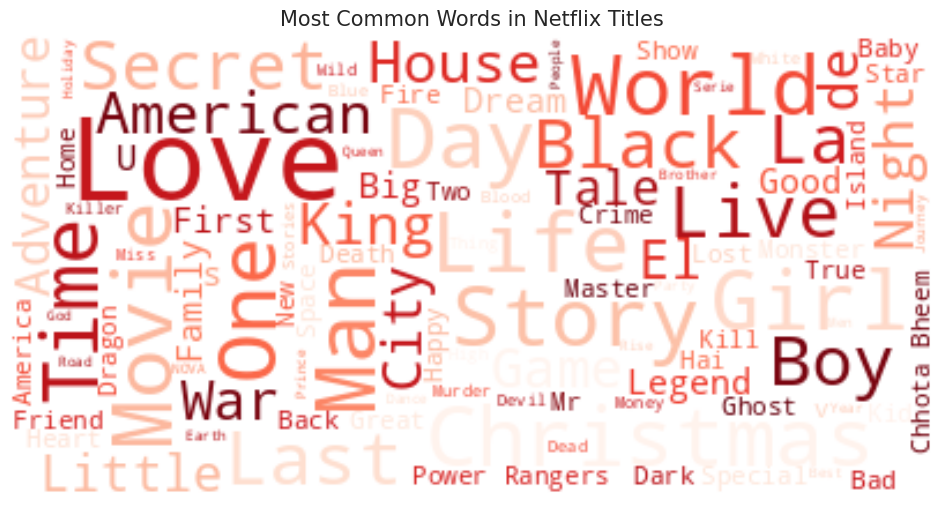

In [9]:
from wordcloud import WordCloud

# Combining all titles into a single string
text = " ".join(title for title in df.title)

# Generating the Word Cloud
# We use 'Reds' colormap to match Netflix branding
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", colormap="Reds").generate(text)

# Plotting the image
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Netflix Titles", fontsize=15)
plt.show()

## 💾 Saving the Cleaned Data
Finally, we export the cleaned and processed dataset for future use.

In [10]:
# Saving to CSV (output will be in the /kaggle/working/ directory)
df.to_csv('netflix_cleaned_eda.csv', index=False)

print("File 'netflix_cleaned_eda.csv' saved successfully!")

File 'netflix_cleaned_eda.csv' saved successfully!
